In [8]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

In [9]:
# ID => This identifies the column name in your dataset that contains a unique identifier for each sample.
ID = ["ID"]
TARGET = ["predefinedlabel"] # Label or output you're trying to predict.
FEATURES = ["Delta", "Theta", "Alpha1", "Alpha2", "Beta1", "Beta2", "Gamma1", "Gamma2"]

# A random seed ensures reproducibility.
SEED = 5412

# the number of samples to be used for training.
NUM_TRAIN_SAMPLES = 70

## Read data

- `SubjectID` = identifies each participant.
- `VideoID` = identifies each video stimulus shown to participants.
- `np.unique(data["VideoID"])` = counts how many unique videos there are.
- `len(np.unique(data["VideoID"])) * data["SubjectID"] + data["VideoID"]` = generates a unique number for each combination of subject and video.

In [10]:
data = pd.read_csv("EEG_data.csv")

data["ID"] = (len(np.unique(data["VideoID"])) * data["SubjectID"] + data["VideoID"]).astype("int")

data = data[ID + FEATURES + TARGET] # Keep the needed column

data

,ID,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel
0,0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0
1,0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0
2,0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0
3,0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0
4,0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0
...,...,...,...,...,...,...,...,...,...,...
12806,99,127574.0,9951.0,709.0,21732.0,3872.0,39728.0,2598.0,960.0,1.0
12807,99,323061.0,797464.0,153171.0,145805.0,39829.0,571280.0,36574.0,10010.0,1.0
12808,99,680989.0,154296.0,40068.0,39122.0,10966.0,26975.0,20427.0,2024.0,1.0
12809,99,366269.0,27346.0,11444.0,9932.0,1939.0,3283.0,12323.0,1764.0,1.0


In [11]:
# reshape_dataset() - converts raw dataframe into
# X: 2D numpy array → each row = one trial (flattened features)
# y: 1D array of class labels for each trial

def reshape_dataset(data):
    features = []
    target = []
    for cur_id in np.unique(data[ID].to_numpy()): # Loops over each unique ID (i.e., each trial)
        cur_id_data = data[data[ID].to_numpy() == cur_id] # Selects all rows corresponding to the current trial
        target.append(np.mean(cur_id_data[TARGET].to_numpy()).astype("int")) # Take the mean of the target
        features.append(cur_id_data[FEATURES].to_numpy()) # Appends the feature matrix for this trial (rows × EEG bands)

    features = pad_sequences(features)
    return np.array(features).reshape(features.shape[0], -1), np.array(target)


# EEG trials may vary in length (e.g., one trial has 5 rows, another has 7),
# but ML models expect equal-sized inputs.
def pad_sequences(arrays, pad_value=0):
    # Pads shorter trials with zeros so all have the same number of rows.
    max_length = max(arr.shape[0] for arr in arrays)
    # Finds the longest trial (in terms of number of rows/time windows)
    padded_arrays = [
        np.pad(
            arr,
            ((0, max_length - arr.shape[0]), (0, 0)),
            mode='constant',
            constant_values=pad_value)
            for arr in arrays
        ]
    # Pads each array with zeros at the bottom to make it as long as max_length.
    return np.stack(padded_arrays)

In [12]:
# Train-test split

np.random.seed(SEED)

unique_ids = np.unique(np.ravel(data[ID]))
train_id = np.random.choice(unique_ids, NUM_TRAIN_SAMPLES, replace=False)
train_index = np.isin(data[ID], train_id)

train = data.iloc[train_index].copy()
test = data.iloc[~train_index].copy()

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (8870, 10)
Test shape: (3941, 10)


In [13]:
# Scaling the data

scaler = StandardScaler()
train[FEATURES] = scaler.fit_transform(train[FEATURES])
test[FEATURES] = scaler.transform(test[FEATURES])

train.head(3)

,ID,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel
0,0,-0.487284,-0.325816,-0.110513,-0.154594,0.106498,0.193042,0.113539,-0.179235,0.0
1,0,-0.843171,-0.588248,-0.564010,-0.537349,-0.593586,-0.470878,-0.334422,-0.362733,0.0
2,0,0.224548,0.904453,2.252233,0.516136,0.338387,1.562871,0.498640,0.384545,0.0


In [14]:
X_train, y_train = reshape_dataset(train)
X_test, y_test = reshape_dataset(test)

print(f"Reshaped Train shapes: {X_train.shape, y_train.shape}")
print(f"Reshaped Test shapes: {X_test.shape, y_test.shape}")

Reshaped Train shapes: ((70, 1152), (70,))
Reshaped Test shapes: ((30, 1152), (30,))


In [15]:
print(X_train[0, 0:8])
print(X_train[0, 8:16])
print(X_train[0, 16:24])

[-0.48728418 -0.32581625 -0.11051269 -0.15459446  0.10649789  0.19304187
  0.11353916 -0.17923454]
[-0.8431708  -0.58824825 -0.56400983 -0.53734868 -0.59358552 -0.47087767
 -0.33442203 -0.36273309]
[0.22454833 0.90445258 2.25223324 0.51613608 0.33838663 1.56287095
 0.49863985 0.38454518]


## Import Classical ML Models

Below we explore 10 classical machine learning models applied to the EEG dataset. All models use the same train/test split and reshaped feature matrix as the linear models.

In [16]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score, f1_score, classification_report

import warnings
warnings.filterwarnings('ignore')

DEFAULT_THR = 0.5

## Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

preds = log_reg.predict(X_test)
binary_preds = (preds > DEFAULT_THR).astype("int")

print(f"ROC AUC score: {roc_auc_score(y_true=y_test, y_score=preds)}")
print(f"F1 score: {f1_score(y_true=y_test, y_pred=binary_preds)}")
print(f"Accuracy score: {accuracy_score(y_true=y_test, y_pred=binary_preds)}")
print(f"Precision score: {precision_score(y_true=y_test, y_pred=binary_preds)}")
print(f"Recall score: {recall_score(y_true=y_test, y_pred=binary_preds)}")

ROC AUC score: 0.6459330143540671
F1 score: 0.6
Accuracy score: 0.6
Precision score: 0.47368421052631576
Recall score: 0.8181818181818182


## Ridge Classifier

In [18]:
from sklearn.linear_model import RidgeClassifier

ridge = RidgeClassifier()
ridge.fit(X_train, y_train)

preds = ridge.predict(X_test)
binary_preds = (preds > DEFAULT_THR).astype("int")

print(f"ROC AUC score: {roc_auc_score(y_true=y_test, y_score=preds)}")
print(f"F1 score: {f1_score(y_true=y_test, y_pred=binary_preds)}")
print(f"Accuracy score: {accuracy_score(y_true=y_test, y_pred=binary_preds)}")
print(f"Precision score: {precision_score(y_true=y_test, y_pred=binary_preds)}")
print(f"Recall score: {recall_score(y_true=y_test, y_pred=binary_preds)}")

ROC AUC score: 0.6722488038277513
F1 score: 0.6206896551724138
Accuracy score: 0.6333333333333333
Precision score: 0.5
Recall score: 0.8181818181818182


## SGD Classifier

In [19]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier()
sgd.fit(X_train, y_train)

preds = sgd.predict(X_test)
binary_preds = (preds > DEFAULT_THR).astype("int")

print(f"ROC AUC score: {roc_auc_score(y_true=y_test, y_score=preds)}")
print(f"F1 score: {f1_score(y_true=y_test, y_pred=binary_preds)}")
print(f"Accuracy score: {accuracy_score(y_true=y_test, y_pred=binary_preds)}")
print(f"Precision score: {precision_score(y_true=y_test, y_pred=binary_preds)}")
print(f"Recall score: {recall_score(y_true=y_test, y_pred=binary_preds)}")

ROC AUC score: 0.6602870813397128
F1 score: 0.5833333333333334
Accuracy score: 0.6666666666666666
Precision score: 0.5384615384615384
Recall score: 0.6363636363636364


In [20]:
# # Prepare reshaped and scaled data
# X_train, y_train = reshape_dataset(train)
# X_test, y_test = reshape_dataset(test)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

## Support Vector Machine (SVM)

The Support Vector Machine is a supervised learning algorithm that tries to find the best decision boundary (hyperplane) that separates different classes with the maximum margin.

In [21]:
from sklearn.svm import SVC
model_svm = SVC(kernel='rbf', probability=True, random_state=SEED)
model_svm.fit(X_train, y_train)
y_pred_svm = model_svm.predict(X_test)
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       1.00      0.05      0.10        19
           1       0.38      1.00      0.55        11

    accuracy                           0.40        30
   macro avg       0.69      0.53      0.33        30
weighted avg       0.77      0.40      0.27        30



## Decision Tree

A Decision Tree splits the data into branches to make decisions based on feature values. It is easy to interpret and visualize.

In [22]:
from sklearn.tree import DecisionTreeClassifier
model_dt = DecisionTreeClassifier(random_state=SEED)
model_dt.fit(X_train, y_train)
y_pred_dt = model_dt.predict(X_test)
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.73      0.58      0.65        19
           1       0.47      0.64      0.54        11

    accuracy                           0.60        30
   macro avg       0.60      0.61      0.59        30
weighted avg       0.64      0.60      0.61        30



## Random Forest

Random Forest is an ensemble method that uses multiple decision trees and combines their outputs to improve performance and reduce overfitting.

In [23]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(n_estimators=100, random_state=SEED)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.86      0.63      0.73        19
           1       0.56      0.82      0.67        11

    accuracy                           0.70        30
   macro avg       0.71      0.72      0.70        30
weighted avg       0.75      0.70      0.71        30



## K-Nearest Neighbors (k-NN)

K-NN is a non-parametric method that classifies a data point based on how its neighbors are classified.

In [24]:
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train, y_train)
y_pred_knn = model_knn.predict(X_test)
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.62      0.42      0.50        19
           1       0.35      0.55      0.43        11

    accuracy                           0.47        30
   macro avg       0.48      0.48      0.46        30
weighted avg       0.52      0.47      0.47        30



## Gradient Boosting

Gradient Boosting builds an ensemble of weak learners (usually decision trees) in a stage-wise manner to minimize a loss function.

In [25]:
from sklearn.ensemble import GradientBoostingClassifier
model_gb = GradientBoostingClassifier(random_state=SEED)
model_gb.fit(X_train, y_train)
y_pred_gb = model_gb.predict(X_test)
print(classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

           0       0.86      0.63      0.73        19
           1       0.56      0.82      0.67        11

    accuracy                           0.70        30
   macro avg       0.71      0.72      0.70        30
weighted avg       0.75      0.70      0.71        30



## Gaussian Naive Bayes

Naive Bayes uses Bayes' Theorem assuming independence between features. It's simple and works surprisingly well for many problems.

In [26]:
from sklearn.naive_bayes import GaussianNB
model_nb = GaussianNB()
model_nb.fit(X_train, y_train)
y_pred_nb = model_nb.predict(X_test)
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       1.00      0.74      0.85        19
           1       0.69      1.00      0.81        11

    accuracy                           0.83        30
   macro avg       0.84      0.87      0.83        30
weighted avg       0.89      0.83      0.84        30



## Multi-Layer Perceptron (MLP)

MLP is a type of neural network composed of layers of nodes. It can learn complex relationships in the data.

In [27]:
from sklearn.neural_network import MLPClassifier
model_mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=SEED)
model_mlp.fit(X_train, y_train)
y_pred_mlp = model_mlp.predict(X_test)
print(classification_report(y_test, y_pred_mlp))

              precision    recall  f1-score   support

           0       0.75      0.63      0.69        19
           1       0.50      0.64      0.56        11

    accuracy                           0.63        30
   macro avg       0.62      0.63      0.62        30
weighted avg       0.66      0.63      0.64        30



## Make a pipeline all at once

In [28]:
# Prepare data
X_train, y_train = reshape_dataset(train)
X_test, y_test = reshape_dataset(test)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

models = {
    'SVM (RBF Kernel)': SVC(kernel='rbf', probability=True, random_state=SEED),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=SEED),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Gradient Boosting': GradientBoostingClassifier(random_state=SEED),
    'Gaussian Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=SEED),
    'MLP (Neural Net)': MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=SEED)
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"{name} Results:")
    print(classification_report(y_test, y_pred))
    print("-" * 60)
    results.append((name, acc, f1))

SVM (RBF Kernel) Results:
              precision    recall  f1-score   support

           0       0.83      0.53      0.65        19
           1       0.50      0.82      0.62        11

    accuracy                           0.63        30
   macro avg       0.67      0.67      0.63        30
weighted avg       0.71      0.63      0.64        30

------------------------------------------------------------
Random Forest Results:
              precision    recall  f1-score   support

           0       0.86      0.63      0.73        19
           1       0.56      0.82      0.67        11

    accuracy                           0.70        30
   macro avg       0.71      0.72      0.70        30
weighted avg       0.75      0.70      0.71        30

------------------------------------------------------------
K-Nearest Neighbors Results:
              precision    recall  f1-score   support

           0       0.75      0.16      0.26        19
           1       0.38      0.91    

In [29]:
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'F1 Score'])
results_df.sort_values(by='F1 Score', ascending=False).reset_index(drop=True)

,Model,Accuracy,F1 Score
0,Gaussian Naive Bayes,0.833333,0.836139
1,Random Forest,0.700000,0.705051
2,Gradient Boosting,0.700000,0.705051
3,MLP (Neural Net),0.700000,0.705051
4,SVM (RBF Kernel),0.633333,0.636188
5,Decision Tree,0.600000,0.607240
6,K-Nearest Neighbors,0.433333,0.363416


## Neural Network with fully connected layers

Simple neural network with fully connected layers and relu activation.

In [30]:
import tensorflow as tf
import random

from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Input, GRU, Dropout

SEED = 5412

np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [31]:
def create_model():
    model = Sequential()
    model.add(Input(shape=(1152,)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["accuracy", AUC(name="auc")])
    return model

model = create_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,569 (146.75 KB)

 Trainable params: 37,569 (146.75 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
NUM_EPOCHS = 20
BATCH_SIZE = 4

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
)

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5335 - auc: 0.6409 - loss: 0.6943 - val_accuracy: 0.7000 - val_auc: 0.7033 - val_loss: 0.7922
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8954 - auc: 0.9768 - loss: 0.3842 - val_accuracy: 0.6667 - val_auc: 0.7081 - val_loss: 0.6854
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9664 - auc: 0.9930 - loss: 0.2847 - val_accuracy: 0.6333 - val_auc: 0.7153 - val_loss: 0.6414
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9492 - auc: 0.9798 - loss: 0.2525 - val_accuracy: 0.7000 - val_auc: 0.6986 - val_loss: 0.7220
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9763 - auc: 0.9959 - loss: 0.1772 - val_accuracy: 0.7667 - val_auc: 0.7177 - val_loss: 0.7440
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9763 - auc: 1.0000 - loss: 0.1381 - val_accuracy: 0.7667 - val_auc: 0.7512 - val_loss: 0.7219
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - 

## Neural Network with GRU layers

In [33]:
X_train_reshaped = X_train.reshape(-1, 144, len(FEATURES))
X_test_reshaped = X_test.reshape(-1, 144, len(FEATURES))

X_train_reshaped.shape, X_test_reshaped.shape

((70, 144, 8), (30, 144, 8))

In [34]:
def create_model():
    model = Sequential()
    model.add(Input(shape=(144, 8)))

    model.add(GRU(20, return_sequences=True, activation='tanh'))
    model.add(GRU(20, return_sequences=True, activation='tanh'))
    model.add(GRU(10, return_sequences=True, activation='tanh'))
    model.add(GRU(10, return_sequences=False, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["accuracy", AUC(name="auc")])
    return model

model = create_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 144, 20)        │         1,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 144, 20)        │         2,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 144, 10)        │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 10)             │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,951 (23.25 KB)

 Trainable params: 5,951 (23.25 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
NUM_EPOCHS = 20
BATCH_SIZE = 4

history = model.fit(
    X_train_reshaped, y_train,
    validation_data=(X_test_reshaped, y_test),
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
)

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.4934 - auc: 0.5240 - loss: 0.6839 - val_accuracy: 0.6333 - val_auc: 0.6986 - val_loss: 0.6538
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7929 - auc: 0.7775 - loss: 0.6129 - val_accuracy: 0.7000 - val_auc: 0.6842 - val_loss: 0.6224
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7929 - auc: 0.8006 - loss: 0.5565 - val_accuracy: 0.7000 - val_auc: 0.6507 - val_loss: 0.5968
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8153 - auc: 0.7938 - loss: 0.5086 - val_accuracy: 0.7000 - val_auc: 0.7249 - val_loss: 0.5758
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.8295 - auc: 0.7933 - loss: 0.4787 - val_accuracy: 0.7000 - val_auc: 0.7440 - val_loss: 0.5535
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.8295 - auc: 0.7747 - loss: 0.4599 - val_accuracy: 0.7333 - val_auc: 0.7679 - val_loss: 0.5345
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/

## Neural Network with GRU layers and dropout

In [36]:
def create_model():
    model = Sequential()
    model.add(Input(shape=(144, 8)))

    model.add(Dropout(0.2))
    model.add(GRU(20, return_sequences=True, activation='tanh'))

    model.add(Dropout(0.2))
    model.add(GRU(20, return_sequences=True, activation='tanh'))

    model.add(Dropout(0.2))
    model.add(GRU(10, return_sequences=True, activation='tanh'))

    model.add(Dropout(0.2))
    model.add(GRU(10, return_sequences=False, activation='tanh'))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["accuracy", AUC(name="auc")])
    return model

model = create_model()
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 144, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 144, 20)        │         1,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 144, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 144, 20)        │         2,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 144, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_6 (GRU)                     │ (None, 144, 10)        │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 144, 10)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 10)             │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,951 (23.25 KB)

 Trainable params: 5,951 (23.25 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
NUM_EPOCHS = 20
BATCH_SIZE = 4

history = model.fit(
    X_train_reshaped, y_train,
    validation_data=(X_test_reshaped, y_test),
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
)

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.6841 - auc: 0.6096 - loss: 0.6457 - val_accuracy: 0.6667 - val_auc: 0.7321 - val_loss: 0.6077
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8122 - auc: 0.8301 - loss: 0.5335 - val_accuracy: 0.6333 - val_auc: 0.7321 - val_loss: 0.5838
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7944 - auc: 0.8315 - loss: 0.4861 - val_accuracy: 0.6667 - val_auc: 0.7608 - val_loss: 0.5623
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8137 - auc: 0.7842 - loss: 0.4718 - val_accuracy: 0.7333 - val_auc: 0.7799 - val_loss: 0.5416
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8137 - auc: 0.8571 - loss: 0.4356 - val_accuracy: 0.7333 - val_auc: 0.7799 - val_loss: 0.5187
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.8264 - auc: 0.8020 - loss: 0.4535 - val_accuracy: 0.7667 - val_auc: 0.7799 - val_loss: 0.4961
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/

## Shap values

In [38]:
import shap
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.lines as mlines

def plot_time_series_with_shap(model, X_train, X_test, y_test, j, feature_names, lags=None):
    X_sample, y_sample = X_test[j], y_test[j]
    background = X_train

    explainer = shap.GradientExplainer(model, background)
    shap_values = explainer.shap_values(np.expand_dims(X_sample, axis=0))[0]
    shap_values = np.squeeze(shap_values)

    num_features = len(feature_names)
    if lags is not None:
        num_features = int(num_features / (1 + len(lags)))
        shap_values = shap_values.reshape(-1, 1 + len(lags), num_features)

        for k, lag in enumerate(lags):
            shap_values[:, k + 1, :] = np.roll(shap_values[:, k + 1, :], shift=lag, axis=0)
            shap_values[:lag, k + 1, :] = 0
        shap_values = np.sum(shap_values, axis=1)

    plt.figure(figsize=(15, 8))
    red_colors = cm.Reds(np.linspace(0.2, 0.9, num_features))  # More color variation in red
    blue_colors = cm.Blues(np.linspace(0.2, 0.9, num_features))  # More color variation in blue
    
    scatter_plots = []
    for i in range(num_features):
        cur_feature_shap_values = shap_values[:, i]
        ts = np.arange(X_sample.shape[0])
        c = [red_colors[i] if el > 0 else blue_colors[i] for el in cur_feature_shap_values]
        s = [250000 * np.abs(el) if 250000 * np.abs(el) > 0.05 else 0.05 for el in cur_feature_shap_values]
        
        plt.scatter(ts, X_sample[:, i], color=c, s=s)
        scatter_plots.append((red_colors[i], blue_colors[i], feature_names[i]))
    
    raw_prediction = model.predict(np.expand_dims(X_sample, axis=0))
    prediction = 'Confused' if raw_prediction > 0.5 else 'Not Confused'
    plt.yscale('log')
    plt.xlabel("Timestep")
    plt.ylabel("Feature Value (Log Scale)")
    
    # Custom legend with both blueish and reddish markers
    legend_handles = [
        mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor=red, markersize=5, label=name)
        for red, blue, name in scatter_plots
    ] + [
        mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor=blue, markersize=5)
        for _, blue, _ in scatter_plots
    ]
    legend_labels = [name for _, _, name in scatter_plots] + ["" for _ in scatter_plots]
    
    plt.legend(handles=legend_handles, labels=legend_labels, loc="upper right", ncol=2, handletextpad=1.5)
    plt.title(f"Sample {j}. True value '{'Confused' if y_sample == 1 else 'Not Confused'}'. Predicted '{prediction}': {np.round(raw_prediction, 2)}%")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


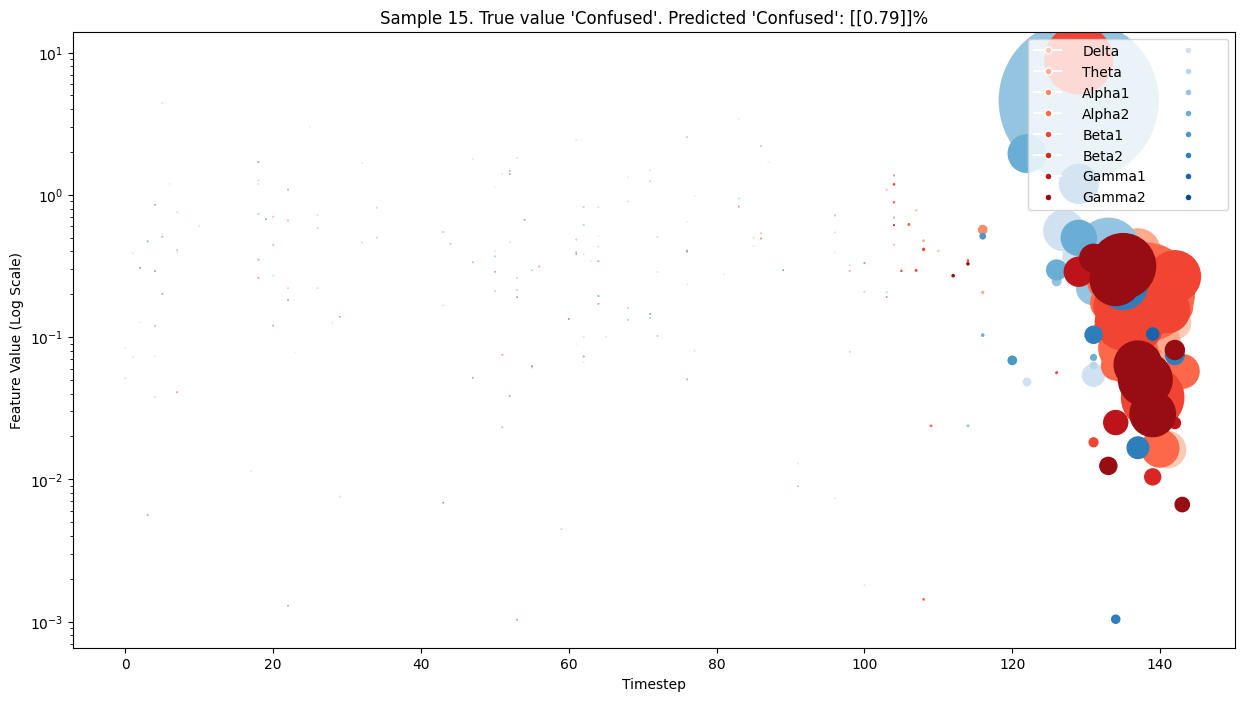

In [39]:
plot_time_series_with_shap(model, X_train_reshaped, X_test_reshaped, y_test, 15, FEATURES)